In [ ]:
import pandas as pd

# Load the excel file, assuming no header row initially
df = pd.read_excel("/content/default of credit card clients.xls", header=None)

# The first row of the loaded DataFrame contains the actual column names
new_columns = df.iloc[0]

# Drop the first two rows. The first row contained headers, and the second seems to contain
# problematic string values that are not part of the actual data.
df = df[2:]

# Set the column names
df.columns = new_columns

# Reset the index
df = df.reset_index(drop=True)

# The target column is now correctly named 'Y' after setting columns. Convert to numeric.
df['Y'] = pd.to_numeric(df['Y'])

df.head()

,NaN,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X15,X16,X17,X18,X19,X20,X21,X22,X23,Y
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [ ]:
X = df.drop("Y", axis=1)
y = df["Y"]

# Convert all column names to strings to avoid TypeError with scikit-learn
X.columns = X.columns.astype(str)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", LogisticRegression(max_iter=1000))
])


In [ ]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = pipeline.predict(X_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

Model Accuracy: 0.8080


The model achieved an accuracy of 80.8%, indicating reasonable overall predictive performance. However, given the imbalanced nature of credit risk data, accuracy alone may not fully capture the model’s effectiveness in identifying defaulters.

Additional metrics such as precision, recall, F1-score, and ROC-AUC are necessary to assess real-world applicability.

In [ ]:
# Compare With a Tree Model
from sklearn.ensemble import RandomForestClassifier

rf_pipeline = Pipeline(steps=[
    ("model", RandomForestClassifier(
        n_estimators=200,
        random_state=42
    ))
])

rf_pipeline.fit(X_train, y_train)


Pipeline(steps=[('model',
                 RandomForestClassifier(n_estimators=200, random_state=42))])

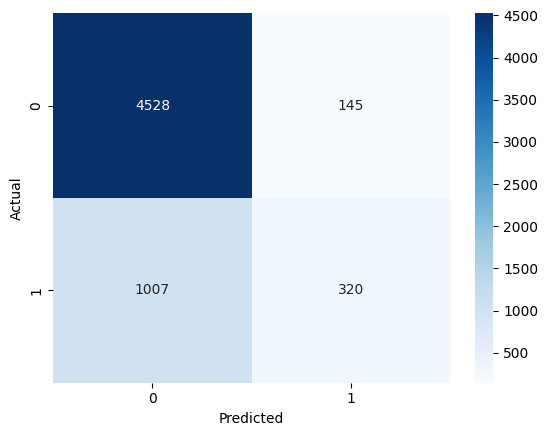

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.61      0.62      6000
weighted avg       0.79      0.81      0.77      6000



The classification results show an overall accuracy of 81%, indicating that the model performs reasonably well on the dataset.

It is very strong at predicting class 0, achieving high precision (0.82) and an excellent recall (0.97), meaning it correctly identifies most negative cases with few false negatives.

However, the model struggles with class 1, where recall is quite low (0.24), indicating that many positive cases are missed despite a moderate precision of 0.69.

This imbalance in performance is reflected in the macro-average metrics, which are notably lower than the weighted averages, suggesting the model is biased toward the majority class.

Overall, while the model is reliable for identifying class 0, it requires improvement—such as better handling of class imbalance or threshold tuning—to effectively capture class 1 instances.

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.ensemble import RandomForestClassifier


In [ ]:
# Defiig aselie Model
rf_base = RandomForestClassifier(
    random_state=42,
    class_weight='balanced'
)

rf_base.fit(X_train, y_train)
y_pred_base = rf_base.predict(X_test)
print(classification_report(y_test, y_pred_base))


              precision    recall  f1-score   support

           0       0.83      0.95      0.89      4673
           1       0.65      0.33      0.44      1327

    accuracy                           0.81      6000
   macro avg       0.74      0.64      0.66      6000
weighted avg       0.79      0.81      0.79      6000



In [ ]:
# DEFINE HYPERPARAMETER GRID
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10],
    'min_samples_leaf': [1, 5]
}


In [ ]:
# Grid Search
grid = GridSearchCV(
    estimator=RandomForestClassifier(
        random_state=42,
        class_weight='balanced'
    ),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1
)

grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [5, 10, None], 'min_samples_leaf': [1, 5],
                         'min_samples_split': [2, 10],
                         'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# best Model and Result
best_model = grid.best_estimator_
y_pred_grid = best_model.predict(X_test)
print(classification_report(y_test, y_pred_grid))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4673
           1       0.56      0.51      0.53      1327

    accuracy                           0.80      6000
   macro avg       0.71      0.70      0.70      6000
weighted avg       0.80      0.80      0.80      6000



In [ ]:
best_model.feature_importances_


array([0.05292657, 0.05167783, 0.0081317 , 0.01194663, 0.00790227,
       0.04106165, 0.12946286, 0.06097188, 0.03970309, 0.02993133,
       0.02470255, 0.01786855, 0.05300023, 0.04625186, 0.04131163,
       0.04172555, 0.03955513, 0.04044618, 0.0500164 , 0.04668012,
       0.04617133, 0.03955448, 0.03807482, 0.04092535])

In [ ]:
# Hyperparameter Tuning
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    random_state=42
)


In [ ]:
# Handlig Class Imbalance
scale_pos_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

xgb = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)


In [ ]:
# Hyperparameter Search Space
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}


In [26]:
from sklearn.model_selection import GridSearchCV
import pandas as pd

grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1,
    verbose=1
)

# Fix: Ensure X_train has numeric types before fitting
# Check for the problematic 'nan' column and drop it if it exists
if 'nan' in X_train.columns:
    X_train = X_train.drop(columns=['nan'])

# Convert all columns to numeric, coercing errors to NaN
for col in X_train.columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')

# Fill any NaNs that might have been introduced during conversion
X_train = X_train.fillna(0) # A simple imputation strategy

grid.fit(X_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='auc', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=No...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 300, 500],
                         'subsample': [0.8, 1.0]},
             scoring='roc_auc', verbose=1)

In [28]:
best_model = grid.best_estimator_

# Fix: Ensure X_test has numeric types and consistent columns for prediction
# Drop the problematic 'nan' column from X_test if it exists
if 'nan' in X_test.columns:
    X_test = X_test.drop(columns=['nan'])

# Convert all columns to numeric, coercing errors to NaN
for col in X_test.columns:
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

# Fill any NaNs that might have been introduced during conversion
X_test = X_test.fillna(0) # A simple imputation strategy, consistent with X_train

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]

In [29]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

ROC AUC Score: 0.7796


The ROC AUC Score for the model is 0.7796. This indicates that the model has a reasonably good ability to distinguish between the positive and negative classes. An AUC score of 0.5 suggests no discrimination (equivalent to random guessing), while a score of 1.0 represents perfect discrimination. Therefore, 0.7796 suggests a fair to good performance in ranking positive instances higher than negative instances.

In [31]:
print("Best model parameters:")
print(grid.best_params_)

Best model parameters:
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}


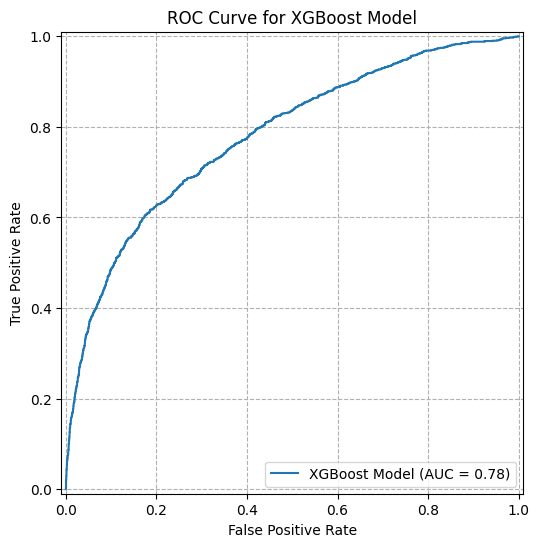

In [32]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

fig, ax = plt.subplots(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax, name='XGBoost Model')
plt.title('ROC Curve for XGBoost Model')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(linestyle='--')
plt.show()

The plot above visually represents the trade-off between the true positive rate (sensitivity) and the false positive rate (1-specificity) at various threshold settings.

A curve that hugs the top-left corner indicates a better performance, as it implies higher true positive rates for lower false positive rates.

The calculated ROC AUC score of 0.7796 supports that the model has a reasonably good discriminatory power, as also reflected by this visual.